In [1]:
%matplotlib widget

from os import path
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from qcnico.coords_io import read_xsf
from qcnico.qcplots import plot_MO
from remove_dangling_carbons import remove_dangling_carbons

def gen_mos(Mdir,lbls,filename_template='MOs_ARPACK_bigMAC'):
    for nn in lbls:
        yield np.load(Mdir+f'/{filename_template}-{nn}.npy')

def gen_energies(edir,lbls,filename_template='eARPACK_bigMAC'):
    for nn in lbls:
        yield np.load(edir+f'/{filename_template}-{nn}.npy')


def gen_pos(posdir, lbls, rCC):
    for nn in lbls:
        yield remove_dangling_carbons(read_xsf(path.join(posdir,f"bigMAC-{nn}_relaxed.xsf"))[0], rCC)



rCC = 1.8

datadir = path.expanduser("~/Desktop/simulation_outputs/percolation/40x40")
posdir = path.join(datadir, "structures")
edir = path.join(datadir, 'eARPACK')
Mdir = path.join(datadir,'MOs_ARPACK')

edir_occ = path.join(edir, 'occupied_cleaned')
edir_vir = path.join(edir, 'virtual_cleaned')

Mdir_occ = path.join(Mdir, 'occupied_cleaned')
Mdir_vir = path.join(Mdir, 'virtual_cleaned')

evenN_lbls = np.load('evenN_lbls.npy')


# eoccs = energies_arpack(edir_occ, evenN_lbls)
# Moccs = mos_arpack(Mdir_occ, evenN_lbls)

# evirs = energies_arpack(edir_vir, evenN_lbls)
# Mvirs = mos_arpack(Mdir_vir, evenN_lbls)

check_pos = gen_pos(posdir, evenN_lbls, rCC)

In [2]:
boys_dir = '/Users/nico/Desktop/simulation_outputs/percolation/40x40/boyz_ARPACK/virtual/'
boys_files = glob(boys_dir + '*npy')
print(boys_files)
lbls_boys = np.array([int(f.split('-')[1].split('.')[0]) for f in boys_files])

sb = set(lbls_boys)
sn = set(evenN_lbls)

boys_lbls = list(sn & sb) # keep only boys MOs of structures with even Natoms
print(boys_lbls)
n_boys_lbls = len(boys_lbls)

edir_vir_og = path.join(edir, 'virtual')
Mdir_vir_og = path.join(Mdir, 'virtual')

evir_ARPACK = gen_energies(edir_vir_og,boys_lbls)
Mvir_ARPACK = gen_mos(Mdir_vir_og,boys_lbls)

Mvir_boys = gen_mos(boys_dir,boys_lbls,filename_template='boyz_MOs_bigMAC')

diffs = np.ones((n_boys_lbls,200)) * -1
max_orth_diff = np.ones(n_boys_lbls) * -1

for k, Ma, Mb in zip(range(n_boys_lbls), Mvir_ARPACK, Mvir_boys):
    nmos_arpack =  Ma.shape[1]
    nmos_boys =  Mb.shape[1]
    assert nmos_arpack == nmos_boys

    diffs[k,:nmos_arpack] = np.linalg.norm(Ma - Mb,axis=0)
    max_orth_diff[k] = np.max(np.abs(np.eye(nmos_boys) - (Mb.T @ Mb)))



print(np.max(diffs[diffs >= 0]))
print(np.mean(diffs[diffs >= 0]))
print(np.min(diffs[diffs >= 0]))

['/Users/nico/Desktop/simulation_outputs/percolation/40x40/boyz_ARPACK/virtual/boyz_MOs_bigMAC-14.npy', '/Users/nico/Desktop/simulation_outputs/percolation/40x40/boyz_ARPACK/virtual/boyz_MOs_bigMAC-28.npy', '/Users/nico/Desktop/simulation_outputs/percolation/40x40/boyz_ARPACK/virtual/boyz_MOs_bigMAC-29.npy', '/Users/nico/Desktop/simulation_outputs/percolation/40x40/boyz_ARPACK/virtual/boyz_MOs_bigMAC-15.npy', '/Users/nico/Desktop/simulation_outputs/percolation/40x40/boyz_ARPACK/virtual/boyz_MOs_bigMAC-9.npy', '/Users/nico/Desktop/simulation_outputs/percolation/40x40/boyz_ARPACK/virtual/boyz_MOs_bigMAC-17.npy', '/Users/nico/Desktop/simulation_outputs/percolation/40x40/boyz_ARPACK/virtual/boyz_MOs_bigMAC-16.npy', '/Users/nico/Desktop/simulation_outputs/percolation/40x40/boyz_ARPACK/virtual/boyz_MOs_bigMAC-12.npy', '/Users/nico/Desktop/simulation_outputs/percolation/40x40/boyz_ARPACK/virtual/boyz_MOs_bigMAC-13.npy', '/Users/nico/Desktop/simulation_outputs/percolation/40x40/boyz_ARPACK/vir

Check if Boys MOs are orthogonal to each other

Max deviation from orthogonality =  7.114309141798003e-13


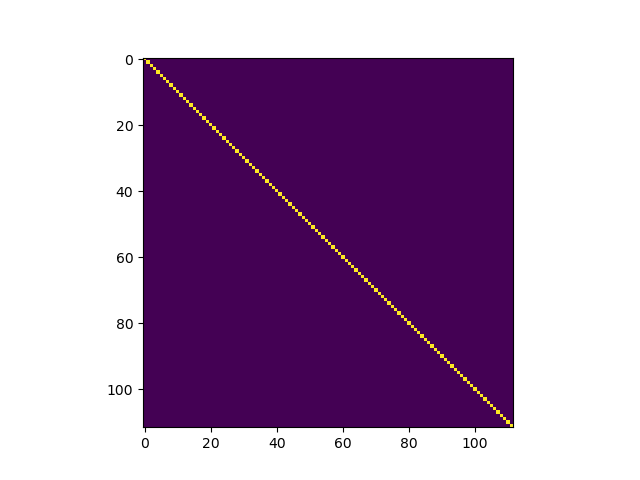

In [3]:
plt.imshow(Mb.T @ Mb)
print('Max deviation from orthogonality = ', np.max(max_orth_diff))

Let's plot the Boys MO which is most different from its corresponding ARPACK MO, using Euclidean distance as the distance quantifier.

Structure ind =  16
MO ind =  71


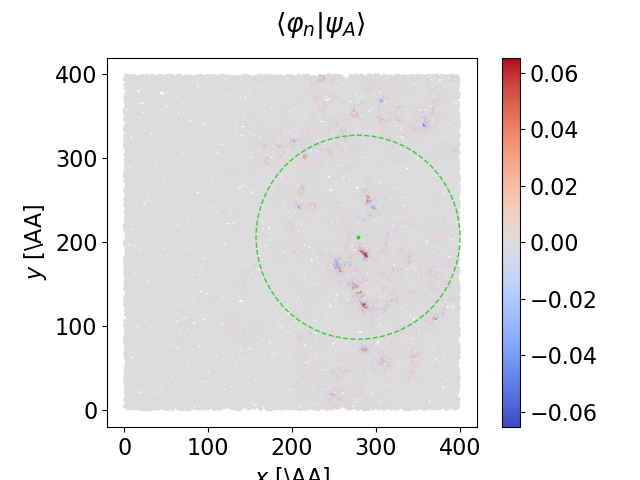

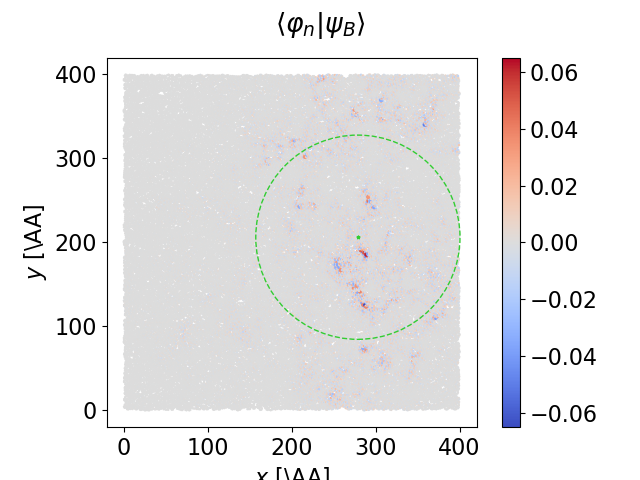

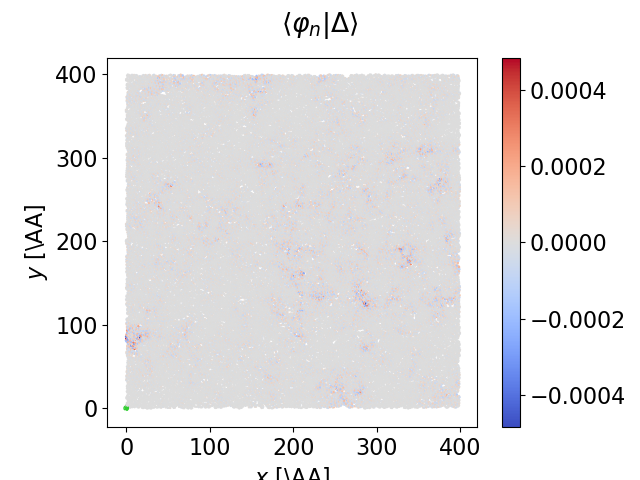

In [4]:
from qcnico.qcplots import plot_MO

ilbl, iMO = np.unravel_index(np.argmax(diffs),diffs.shape)
nn = boys_lbls[ilbl]
print('Structure ind = ', nn)
print('MO ind = ', iMO)

pos = remove_dangling_carbons(read_xsf(path.join(posdir,f"bigMAC-{nn}_relaxed.xsf"))[0], rCC)
Marpack = np.load(path.join(Mdir_vir_og, f'MOs_ARPACK_bigMAC-{nn}.npy'))
Mboys = np.load(path.join(boys_dir, f'boyz_MOs_bigMAC-{nn}.npy'))

Mdiff = Marpack - Mboys

plot_MO(pos,Marpack,iMO, dotsize=0.5,scale_up=8.5,show_COM=True,show_rgyr=True,usetex=False,plot_amplitude=True,cmap='coolwarm',com_clr='limegreen',title=r'$\langle\varphi_n|\psi_{A}\rangle$')
plot_MO(pos,Mboys,iMO, dotsize=0.5,scale_up=8.5,show_COM=True,show_rgyr=True,usetex=False,plot_amplitude=True,cmap='coolwarm',com_clr='limegreen',title=r'$\langle\varphi_n|\psi_{B}\rangle$')
plot_MO(pos,Mdiff,iMO, dotsize=0.5,scale_up=8.5,show_COM=True,show_rgyr=True,usetex=False,plot_amplitude=True,cmap='coolwarm',com_clr='limegreen',title=r'$\langle\varphi_n|\Delta\rangle$')


Let's plot the Boys MO which is most different from its corresponding ARPACK MO, using dot product as the distance quantifier.

['/Users/nico/Desktop/simulation_outputs/percolation/40x40/boyz_ARPACK/virtual/boyz_MOs_bigMAC-14.npy', '/Users/nico/Desktop/simulation_outputs/percolation/40x40/boyz_ARPACK/virtual/boyz_MOs_bigMAC-28.npy', '/Users/nico/Desktop/simulation_outputs/percolation/40x40/boyz_ARPACK/virtual/boyz_MOs_bigMAC-29.npy', '/Users/nico/Desktop/simulation_outputs/percolation/40x40/boyz_ARPACK/virtual/boyz_MOs_bigMAC-15.npy', '/Users/nico/Desktop/simulation_outputs/percolation/40x40/boyz_ARPACK/virtual/boyz_MOs_bigMAC-9.npy', '/Users/nico/Desktop/simulation_outputs/percolation/40x40/boyz_ARPACK/virtual/boyz_MOs_bigMAC-17.npy', '/Users/nico/Desktop/simulation_outputs/percolation/40x40/boyz_ARPACK/virtual/boyz_MOs_bigMAC-16.npy', '/Users/nico/Desktop/simulation_outputs/percolation/40x40/boyz_ARPACK/virtual/boyz_MOs_bigMAC-12.npy', '/Users/nico/Desktop/simulation_outputs/percolation/40x40/boyz_ARPACK/virtual/boyz_MOs_bigMAC-13.npy', '/Users/nico/Desktop/simulation_outputs/percolation/40x40/boyz_ARPACK/vir

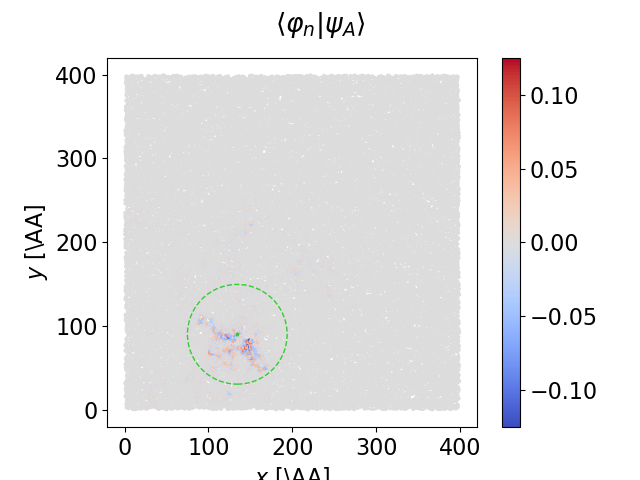

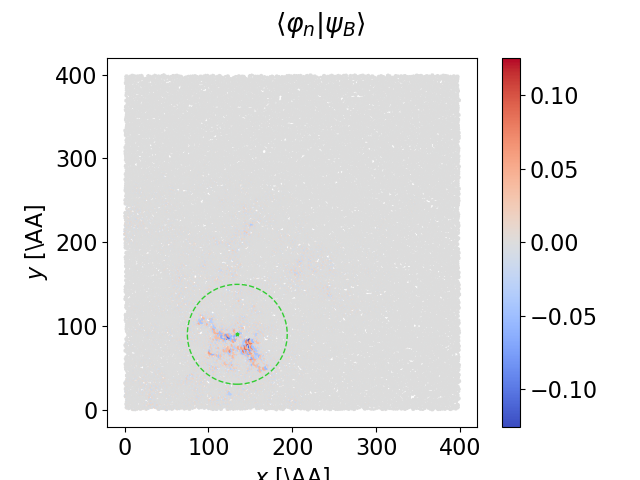

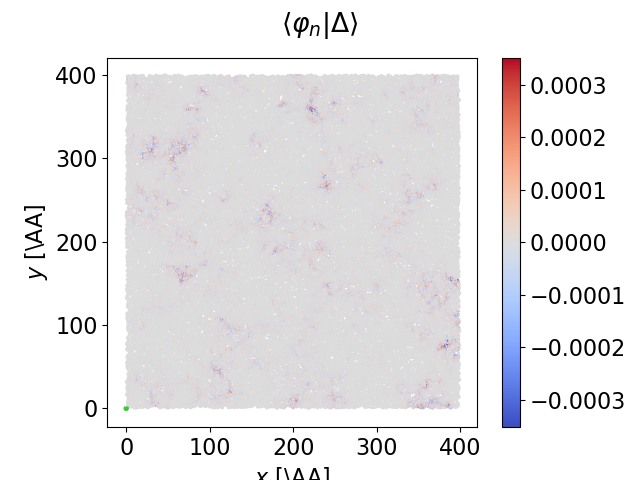

In [5]:
boys_dir = '/Users/nico/Desktop/simulation_outputs/percolation/40x40/boyz_ARPACK/virtual/'
boys_files = glob(boys_dir + '*npy')
print(boys_files)
lbls_boys = np.array([int(f.split('-')[1].split('.')[0]) for f in boys_files])

sb = set(lbls_boys)
sn = set(evenN_lbls)

boys_lbls = list(sn & sb) # keep only boys MOs of structures with even Natoms
print(boys_lbls)
n_boys_lbls = len(boys_lbls)

edir_vir_og = path.join(edir, 'virtual')
Mdir_vir_og = path.join(Mdir, 'virtual')

evir_ARPACK = gen_energies(edir_vir_og,boys_lbls)
Mvir_ARPACK = gen_mos(Mdir_vir_og,boys_lbls)

Mvir_boys = gen_mos(boys_dir,boys_lbls,filename_template='boyz_MOs_bigMAC')

dots = np.ones((n_boys_lbls,200)) * -1

for k, Ma, Mb in zip(range(n_boys_lbls), Mvir_ARPACK, Mvir_boys):
    nmos_arpack =  Ma.shape[1]
    nmos_boys =  Mb.shape[1]
    assert nmos_arpack == nmos_boys

    dots[k,:nmos_arpack] = np.abs((Ma.T @ Mb).diagonal())
    max_orth_diff[k] = np.max(np.abs(np.eye(nmos_boys) - (Mb.T @ Mb)))



print(np.max(dots[dots >= 0]))
print(np.mean(dots[dots >= 0]))
print(np.min(dots[dots >= 0]))

ilbl, iMO = np.unravel_index(np.argmin(dots[dots>=0]),dots.shape)
nn = boys_lbls[ilbl]
print('Structure ind = ', nn)
print('MO ind = ', iMO)

pos = remove_dangling_carbons(read_xsf(path.join(posdir,f"bigMAC-{nn}_relaxed.xsf"))[0], rCC)
Marpack = np.load(path.join(Mdir_vir_og, f'MOs_ARPACK_bigMAC-{nn}.npy'))
Mboys = np.load(path.join(boys_dir, f'boyz_MOs_bigMAC-{nn}.npy'))

Mdiff = Marpack - Mboys

plot_MO(pos,Marpack,iMO, dotsize=0.5,scale_up=8.5,show_COM=True,show_rgyr=True,usetex=False,plot_amplitude=True,cmap='coolwarm',com_clr='limegreen',title=r'$\langle\varphi_n|\psi_{A}\rangle$')
plot_MO(pos,Mboys,iMO, dotsize=0.5,scale_up=8.5,show_COM=True,show_rgyr=True,usetex=False,plot_amplitude=True,cmap='coolwarm',com_clr='limegreen',title=r'$\langle\varphi_n|\psi_{B}\rangle$')
plot_MO(pos,Mdiff,iMO, dotsize=0.5,scale_up=8.5,show_COM=True,show_rgyr=True,usetex=False,plot_amplitude=True,cmap='coolwarm',com_clr='limegreen',title=r'$\langle\varphi_n|\Delta\rangle$')

[plt_utils.histogram] dx = 7.955698403949718e-08


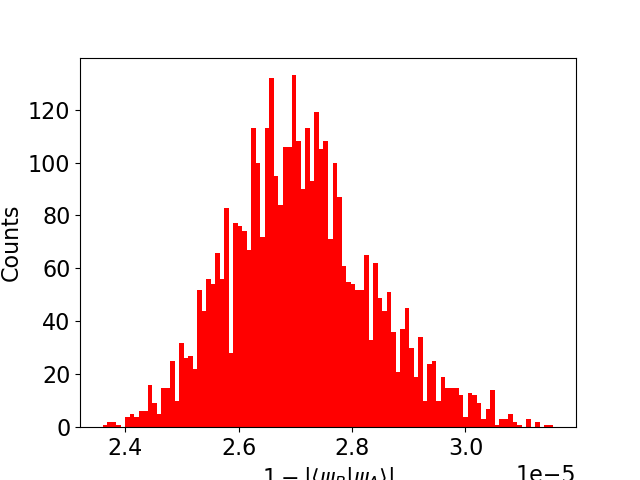

In [6]:
from qcnico.plt_utils import histogram

histogram(1-dots[dots>=0], xlabel=r'$ 1- |\langle\psi_B|\psi_A\rangle|$')

In [7]:
boys_dir = '/Users/nico/Desktop/simulation_outputs/percolation/40x40/boyz_ARPACK/virtual/'
boys_files = glob(boys_dir + '*npy]')
lbls_boyz = set([int(f.split('-')[0].split('.')) for f in boys_files])

0
1
2


KeyboardInterrupt: 

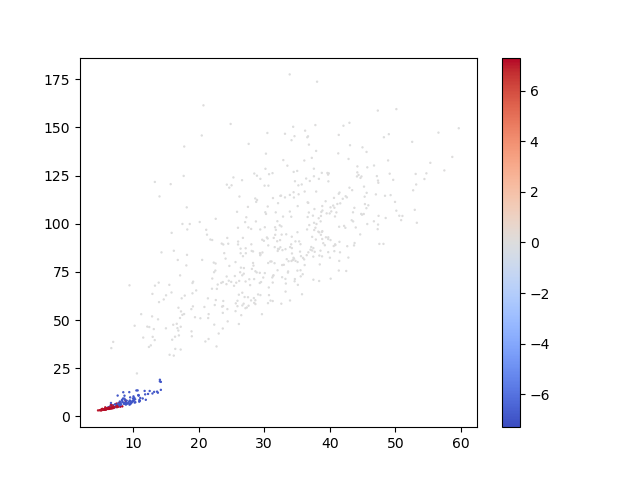

In [2]:

from qcnico.qchemMAC import inverse_participation_ratios, MO_rgyr
import matplotlib.colors as colors


edir_occ = path.join(edir, 'occupied_cleaned')
edir_vir = path.join(edir, 'virtual_cleaned')
edir_lo = path.join(edir, 'lo')
edir_hi = path.join(edir, 'hi')

Mdir_occ = path.join(Mdir, 'occupied_cleaned')
Mdir_vir = path.join(Mdir, 'virtual_cleaned')
Mdir_lo = path.join(Mdir, 'lo')
Mdir_hi = path.join(Mdir, 'hi')

eoccs = gen_energies(edir_occ,evenN_lbls)
Moccs = gen_mos(Mdir_occ,evenN_lbls)

elo = gen_energies(edir_lo, evenN_lbls,filename_template='eARPACK_lo_bigMAC')
Mlo = gen_mos(Mdir_lo,evenN_lbls,filename_template='MOs_ARPACK_lo_bigMAC')

evirs = gen_energies(edir_vir,evenN_lbls)
Mvirs = gen_mos(Mdir_vir,evenN_lbls)

ehi = gen_energies(edir_hi, evenN_lbls,filename_template='eARPACK_hi_bigMAC')
Mhi = gen_mos(Mdir_hi,evenN_lbls,filename_template='MOs_ARPACK_hi_bigMAC')

pos = gen_pos(posdir,evenN_lbls,rCC)

nlbls =evenN_lbls.shape[0]

fig, ax = plt.subplots()

for k, eoccs, evirs, Mocc, Mvir, elo, Mlo, ehi, Mhi, pos in zip(range(nlbls),eoccs,evirs,Moccs,Mvirs,elo,Mlo,ehi,Mhi,pos):
    print(k)
    ioccs = np.argsort(eoccs)
    ivirs = np.argsort(evirs)
    ilo = np.argsort(elo)
    ihi = np.argsort(ehi)

    eoccs = eoccs[ioccs]    
    evirs = evirs[ivirs]
    elo = elo[ilo]
    ehi = ehi[ihi]

    Mocc = Mocc[:,ioccs]    
    Mvir = Mvir[:,ivirs]
    Mlo = Mlo[:,ilo]
    Mhi = Mhi[:,ihi]

    eF_approx = (eoccs[-1] + evirs[0]) * 0.5 #approximate because the extremal occ/virt energies are not necessarily eHOMO/eLUMO


    energies = np.hstack((elo, eoccs, evirs, ehi)) - eF_approx
    M = np.hstack((Mlo, Mocc, Mvir, Mhi))

    iprs = 1.0/np.sqrt(inverse_participation_ratios(M))
    rgyrs = MO_rgyr(pos, M)

    if k == 0:
        ye = ax.scatter(iprs,rgyrs,marker='o',c=energies,s=0.5, cmap='coolwarm', norm = colors.CenteredNorm()) #CenteredNorm sets the midpoint of the colormap to 0
        # ye = ax.scatter(iprs,rgyrs,marker='o',c=np.abs(energies),s=0.5, cmap='viridis',alpha=0.5)
        cbar = fig.colorbar(ye,ax=ax)

    else:
        ye = ax.scatter(iprs,rgyrs,marker='o',c=energies,s=0.5, cmap='coolwarm', norm = colors.CenteredNorm())
        # ye = ax.scatter(iprs,rgyrs,marker='o',c=np.abs(energies),s=0.5, cmap='viridis',alpha=0.5)

ax.set_ylabel('$\sqrt{\langle R^2\\rangle - \langle R\\rangle^2}$')
ax.set_xlabel('1/$\sqrt{IPR}$')
plt.show()

## Radii of gyration of low- and high-energy extremal MOs

[plt_utils.histogram] dx = 0.38684407440071644
[plt_utils.histogram] dx = 0.11054954819207553


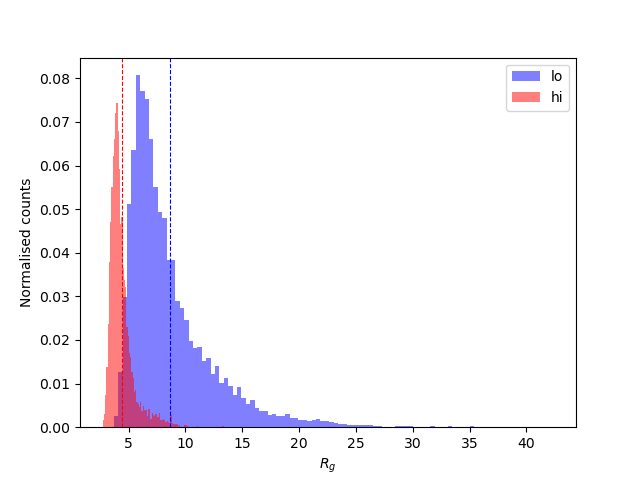

<R_g(lo)> =  8.640179723212528
<R_g(hi)> =  4.377867979445986


In [2]:
from qcnico.qchemMAC import MO_rgyr
from qcnico.plt_utils import histogram

Mdir_lo = path.join(Mdir, 'lo')
Mdir_hi = path.join(Mdir, 'hi')

Mlos = gen_mos(Mdir_lo,evenN_lbls,filename_template='MOs_ARPACK_lo_bigMAC')
Mhis = gen_mos(Mdir_hi,evenN_lbls,filename_template='MOs_ARPACK_hi_bigMAC')

all_pos = gen_pos(posdir,evenN_lbls,rCC)

nlbls =evenN_lbls.shape[0]
nMOs = 50

rgyrs_lo = np.zeros(nlbls*nMOs)
rgyrs_hi = np.zeros(nlbls*nMOs)

for k, Mlo, Mhi, pos in zip(range(nlbls), Mlos, Mhis, all_pos):
    rgyrs_lo[50*k:50*(k+1)] = MO_rgyr(pos,Mlo)
    rgyrs_hi[50*k:50*(k+1)] = MO_rgyr(pos,Mhi)

fig, ax = plt.subplots()

histogram(rgyrs_lo,normalised=True,plt_objs=(fig,ax),plt_kwargs={'color':'b', 'alpha':0.5,'label':'lo'}, show=False)
histogram(rgyrs_hi,normalised=True,plt_objs=(fig,ax),plt_kwargs={'color':'r', 'alpha':0.5,'label':'hi'}, show=False)

ax.set_xlabel('$R_g$')

ax.axvline(x=np.mean(rgyrs_lo),ymin=0,ymax=1,c='b',lw=0.8,ls='--')
ax.axvline(x=np.mean(rgyrs_hi),ymin=0,ymax=1,c='r',lw=0.8,ls='--')

plt.legend()
plt.show()

print('<R_g(lo)> = ',np.mean(rgyrs_lo))
print('<R_g(hi)> = ',np.mean(rgyrs_hi))

***** 3 *****
new_vals:  [[3.00000000e+00 6.80000000e+01 3.79719798e-02]
 [3.00000000e+00 3.90000000e+01 3.23542991e-02]
 [3.00000000e+00 4.00000000e+00 2.83660733e-02]
 [3.00000000e+00 1.10000000e+01 2.80818741e-02]
 [3.00000000e+00 5.60000000e+01 2.73886106e-02]]
max_alphas_occ =  [[3.00000000e+00 6.80000000e+01 3.79719798e-02]
 [3.00000000e+00 3.90000000e+01 3.23542991e-02]
 [3.00000000e+00 4.00000000e+00 2.83660733e-02]
 [3.00000000e+00 1.10000000e+01 2.80818741e-02]
 [3.00000000e+00 5.60000000e+01 2.73886106e-02]]
new_vals:  [[3.00000000e+00 1.03000000e+02 5.96744582e-02]
 [3.00000000e+00 6.40000000e+01 4.22775727e-02]
 [3.00000000e+00 8.50000000e+01 3.42984593e-02]
 [3.00000000e+00 6.10000000e+01 3.29302946e-02]
 [3.00000000e+00 3.60000000e+01 3.14532073e-02]]
max_alphas_vir =  [[3.00000000e+00 1.03000000e+02 5.96744582e-02]
 [3.00000000e+00 6.40000000e+01 4.22775727e-02]
 [3.00000000e+00 8.50000000e+01 3.42984593e-02]
 [3.00000000e+00 6.10000000e+01 3.29302946e-02]
 [3.00000000e

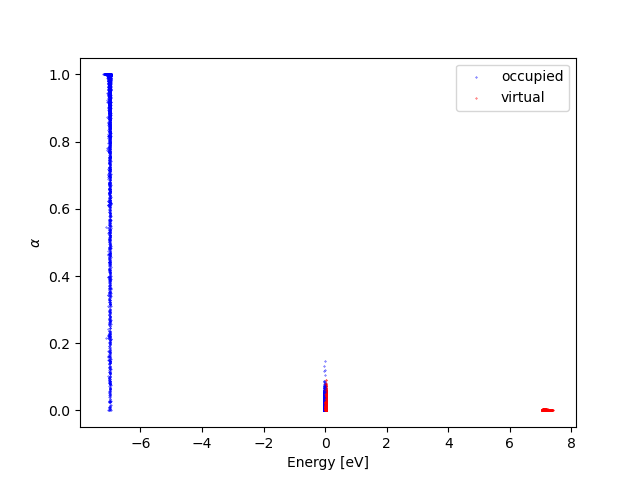

In [2]:
from qcnico.qchemMAC import alpha_LEGS

def update_max_alphas(max_alphas, local_alphas, nstruc):
    iglobal = 0 
    ilocal = 0
    nb_global_maxs = max_alphas.shape[0]

    sorted_local_inds = np.argsort(-local_alphas) #sort in descending order; 1st elem is argmax

    new_vals = np.ones((nb_global_maxs,3)) * -1
    
    while iglobal < nb_global_maxs:
        ii = sorted_local_inds[ilocal]
        check = max_alphas[iglobal,2] < local_alphas[ii]
        if check:
            new_vals[iglobal,:] = np.array([nstruc,ii,local_alphas[ii]])
            ilocal += 1
        iglobal += 1
    
    print('new_vals: ', new_vals)

    changed_global = (new_vals >= 0).nonzero()[0]
    if changed_global.shape[0] > 0:
        # changed_global = changed_global[::-1] #work from the end of the global array, minimizes how many changes need to be done to max_alphas
        for ichange in changed_global:
            if ichange == 0:
                max_alphas = np.roll(max_alphas,1,axis=0)
                max_alphas[0,:] = new_vals[0,:]
            elif ichange < nb_global_maxs - 1 and ichange > 0 :
                unchanged = max_alphas[:ichange,:]
                to_change = np.roll(max_alphas[ichange:,:],1,axis=0)
                to_change[0,:] = new_vals[ichange]
                max_alphas = np.vstack((unchanged,to_change))
            else: # ichange == nb_global_maxs
                max_alphas[ichange,:] = new_vals[ichange,:]
    
    return max_alphas


edir_occ = path.join(edir, 'occupied_cleaned')
edir_vir = path.join(edir, 'virtual_cleaned')
edir_lo = path.join(edir, 'lo')
edir_hi = path.join(edir, 'hi')

Mdir_occ = path.join(Mdir, 'occupied_cleaned')
Mdir_vir = path.join(Mdir, 'virtual_cleaned')
Mdir_lo = path.join(Mdir, 'lo')
Mdir_hi = path.join(Mdir, 'hi')

eoccs = gen_energies(edir_occ,evenN_lbls)
Moccs = gen_mos(Mdir_occ,evenN_lbls)

elo = gen_energies(edir_lo, evenN_lbls,filename_template='eARPACK_lo_bigMAC')
Mlo = gen_mos(Mdir_lo,evenN_lbls,filename_template='MOs_ARPACK_lo_bigMAC')

evirs = gen_energies(edir_vir,evenN_lbls)
Mvirs = gen_mos(Mdir_vir,evenN_lbls)

ehi = gen_energies(edir_hi, evenN_lbls,filename_template='eARPACK_hi_bigMAC')
Mhi = gen_mos(Mdir_hi,evenN_lbls,filename_template='MOs_ARPACK_hi_bigMAC')

pos = gen_pos(posdir,evenN_lbls,rCC)
        
fig, ax = plt.subplots()

max_alphas_occ = np.zeros((5,3)) #stores the structure index, state index, and alpha value of occ states w 5 highest alpha in desc order
max_alphas_vir = np.zeros((5,3)) #stores the structure index, state index, and alpha value of vir states w 5 highest alpha in desc order
max_alphas_lo = np.zeros((5,3)) #stores the structure index, state index, and alpha value of lo states w 5 highest alpha in desc order
max_alphas_hi = np.zeros((5,3)) #stores the structure index, state index, and alpha value of hi states w 5 highest alpha in desc order

k = 0
for pos, eloo, eocc, evir, ehii, mlo, Mocc, Mvir, mhi in zip(check_pos, elo, eoccs, evirs, ehi, Mlo, Moccs, Mvirs, Mhi):
    n = evenN_lbls[k]
    print(f'***** {n} *****')
    # print(n)
    eHOMO = eocc[0] #occupied energies are sorted in descending order
    eocc -= eHOMO
    eocc = eocc[::-1] #reverse order of eocc
    eloo -= eHOMO
    
    eLUMO = evir[0] #vitrual energies are sorted in ascending order 
    evir -= eLUMO 
    ehii -= eLUMO


    # energies = np.hstack((eocc, evir))

    Mocc = Mocc[:,::-1] #reverse order of columns of Mocc
    # M = np.hstack((Mocc, Mvir))

    alphas_occ = alpha_LEGS(Mocc)
    max_alphas_occ = update_max_alphas(max_alphas_occ, alphas_occ, n)
    print('max_alphas_occ = ', max_alphas_occ)

    alphas_vir = alpha_LEGS(Mvir)
    max_alphas_vir = update_max_alphas(max_alphas_vir, alphas_vir, n)
    print('max_alphas_vir = ', max_alphas_vir)

    alphas_lo = alpha_LEGS(mlo)
    max_alphas_lo = update_max_alphas(max_alphas_lo, alphas_lo, n)
    print('max_alphas_lo = ', max_alphas_lo)
    
    alphas_hi = alpha_LEGS(mhi)
    max_alphas_hi = update_max_alphas(max_alphas_hi, alphas_hi, n)
    print('max_alphas_hi = ', max_alphas_hi)

    if k == 0:
        ax.scatter(eocc,alphas_occ,c='b',s=0.1,label='occupied')
    else:
        ax.scatter(eocc,alphas_occ,c='b',s=0.1)
    
    ax.scatter(eloo,alphas_lo,c='b',s=0.1)

    print('max_alphas_vir = ', max_alphas_vir)
    if k == 0:
        ax.scatter(evir,alphas_vir,c='r',s=0.1,label='virtual')
    else:
        ax.scatter(evir,alphas_vir,c='r',s=0.1)
    
    ax.scatter(ehii, alphas_hi, c='r', s=0.1)
    
    k+=1

ax.set_xlabel('Energy [eV]')
ax.set_ylabel('$\\alpha$')

# max_alpha_eoccs = gen_energies(edir_occ,max_alphas_occ[:,0].astype(int))
# max_alpha_evirs = energies_arpack(edir_vir,max_alphas_vir[:,0].astype(int))

# for mao, energies in zip(max_alphas_occ, max_alpha_eoccs):
#     eHOMO = np.max(energies)
#     energies = energies[::-1]
#     e = energies[int(mao[1])] - eHOMO
#     alpha = mao[2]
#     ax.scatter(e,alpha,facecolors=['none'], edgecolors=['fuchsia'],s=15.0)

# for mav, energies in zip(max_alphas_vir, max_alpha_evirs):
#     eLUMO = energies[0]
#     e = energies[int(mav[1])] - eLUMO
#     alpha = mav[2]
#     ax.scatter(e,alpha,facecolors=['none'], edgecolors=['fuchsia'],s=15.0)

plt.legend()
plt.show()



[116 116]
[289 289]


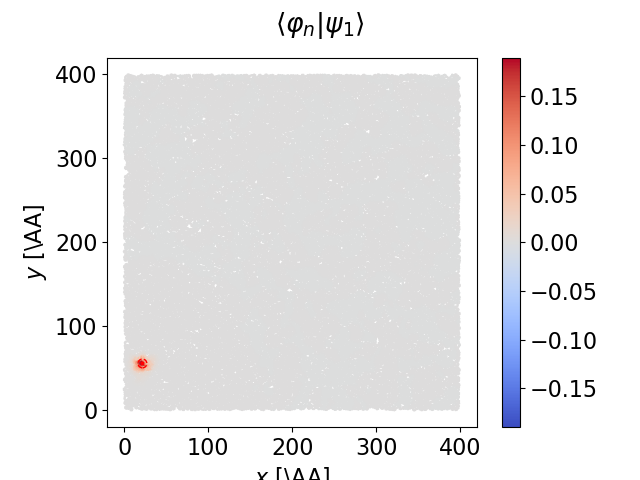

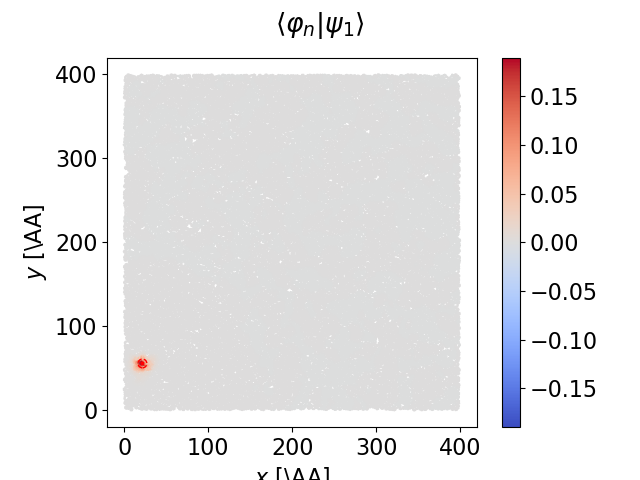

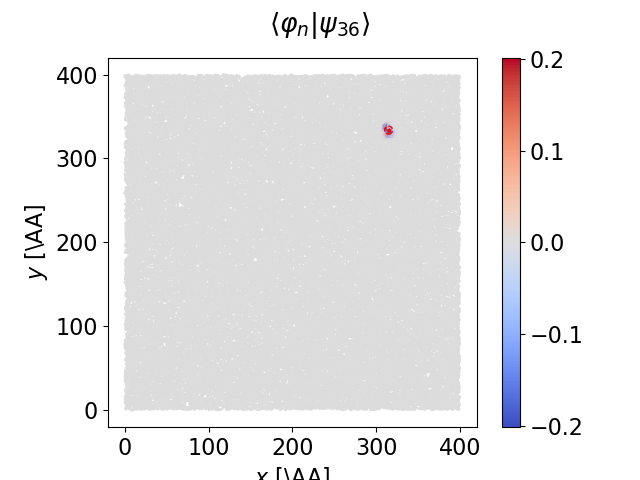

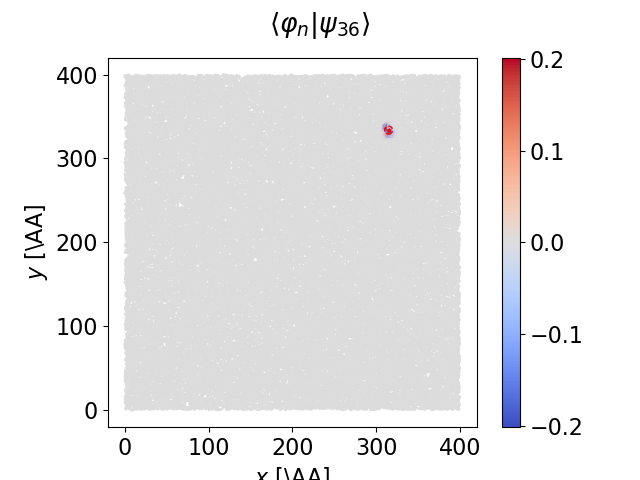

In [5]:
max_alpha_lo_lbls = max_alphas_lo[:2,0].astype(int)
aMlo = gen_mos(Mdir_lo, max_alpha_lo_lbls,filename_template='MOs_ARPACK_lo_bigMAC')
apos_lo = gen_pos(posdir, max_alpha_lo_lbls, rCC)

max_alpha_hi_lbls = max_alphas_hi[:2,0].astype(int)
aMhi = gen_mos(Mdir_hi, max_alpha_hi_lbls,filename_template='MOs_ARPACK_hi_bigMAC')
apos_hi = gen_pos(posdir, max_alpha_hi_lbls, rCC)

print(max_alpha_lo_lbls)
print(max_alpha_hi_lbls)

for mao, M, pos in zip(max_alphas_lo, aMlo, apos_lo):
    iMO = int(mao[1])
    plot_MO(pos,M,iMO,dotsize=0.5,scale_up=8.5,show_COM=True,show_rgyr=True,show=True,usetex=False, plot_amplitude=True,cmap='coolwarm')

for mav, M, pos in zip(max_alphas_hi, aMhi, apos_hi):
    iMO = int(mav[1])
    plot_MO(pos,M,iMO,dotsize=0.5,scale_up=8.5,show_COM=True,show_rgyr=True,show=True,usetex=False, plot_amplitude=True, cmap='coolwarm')